In [171]:
import cdflib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LogNorm

In [172]:
path = 'DATA/dmsp-f16_20110502.cdf'
cdflib.cdf_to_xarray(path)

<xarray.Dataset>
Dimensions:                    (Epoch: 86400, dim0: 3, CHANNEL_ENERGIES: 19,
                                dim1: 19)
Coordinates:
  * Epoch                      (Epoch) float64 6.347e+13 6.347e+13 ... 6.347e+13
  * CHANNEL_ENERGIES           (CHANNEL_ENERGIES) float32 3e+04 ... 30.0
Dimensions without coordinates: dim0, dim1
Data variables: (12/26)
    SC_ECI                     (Epoch, dim0) float64 -273.6 ... -5.473e+03
    SC_ECI_LABEL               (dim0) <U5 'x_ECI' 'y_ECI' 'z_ECI'
    SC_GEOCENTRIC_LAT          (Epoch) float64 -80.07 -80.1 ... -49.25 -49.19
    SC_GEOCENTRIC_LON          (Epoch) float64 37.77 37.47 37.16 ... 287.8 287.8
    SC_GEOCENTRIC_R            (Epoch) float64 7.235e+03 7.235e+03 ... 7.23e+03
    SC_AACGM_LAT               (Epoch) float64 -74.23 -74.2 ... -40.65 -40.6
    ...                         ...
    ION_DIFF_ENERGY_FLUX       (Epoch, CHANNEL_ENERGIES) float32 2.868e+04 .....
    ION_DIFF_ENERGY_FLUX_STD   (Epoch, CHANNEL_ENERGIES) float32 1.118 ... nan
    ION_TOTAL_ENERGY_FLUX      (Epoch) float32 6.907e+09 6.961e+09 ... 0.0
    ION_TOTAL_ENERGY_FLUX_STD  (Epoch) float32 0.3838 0.3954 0.3604 ... 1.84 nan
    ION_AVG_ENERGY             (Epoch) float32 7.712e+03 6.878e+03 ... nan
    ION_AVG_ENERGY_STD         (Epoch) float32 0.5086 0.5146 0.5117 ... 2.66 nan
Attributes: (12/26)
    Project:                     DMSP
    Source_name:                 dmsp-f16
    Discipline:                  ['Space Physics>Magnetospheric Science', 'Sp...
    Data_type:                   precipitating-electrons-ions
    Descriptor:                  ssj
    File_naming_convention:      source_descriptor_datatype_yyyyMMdd
    ...                          ...
    MODS:                        This is version 1, beta.
    LINK_TEXT:                   NGDC Solar & Terrestrial Physics Satellite D...
    LINK_TITLE:                  NGDC STP Satellite Data Services
    HTTP_LINK:                   http://www.ngdc.noaa.gov/stp/satellite/satda...
    DWELL_TIME:                  The count integration time at each energy st...
    VERSION:                      1.1.2

In [173]:
cdf_file = cdflib.CDF(path)
ion = cdf_file['ION_DIFF_ENERGY_FLUX']
ele = cdf_file['ELE_DIFF_ENERGY_FLUX']
channel = cdf_file['CHANNEL_ENERGIES']

In [174]:
from datetime import datetime


a = cdflib.cdfepoch.unixtime(cdf_file['Epoch'])
date = [datetime.utcfromtimestamp(aa) for aa in a]

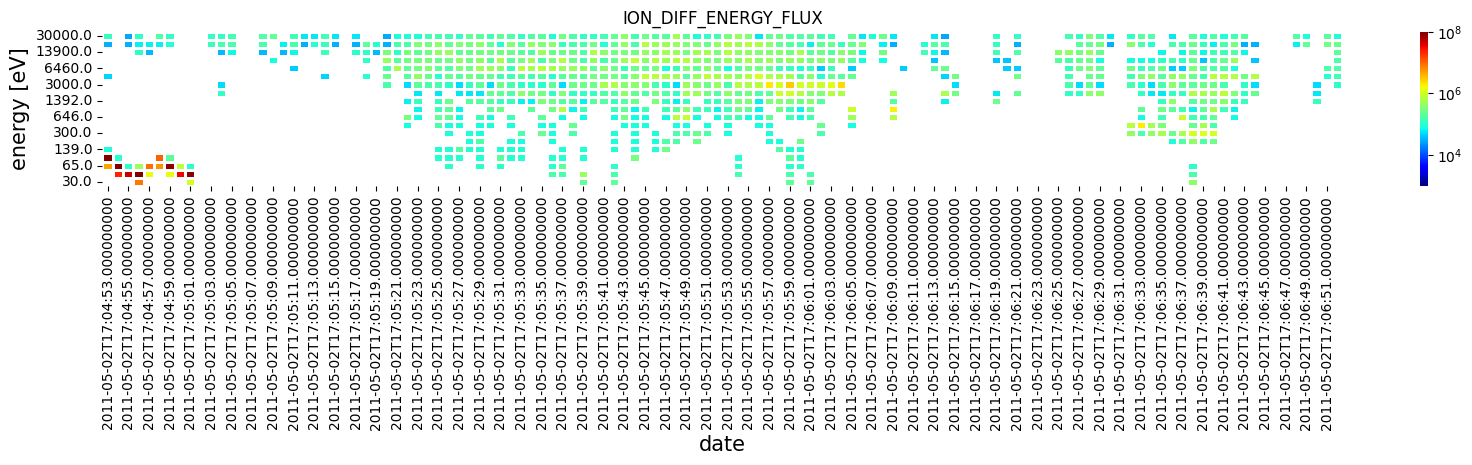

In [324]:
st = 61493
et = st + 120
df_ion = pd.DataFrame(ion.T[:, st:et], columns=date[st:et], index=channel)
df_ion_mask = (df_ion == 0)
plt.figure(figsize=(20,2))
sns.heatmap(df_ion, linewidths = 1,cmap = "jet", mask = df_ion_mask, norm=LogNorm(vmin=1e3,vmax=1e8))
plt.title('ION_DIFF_ENERGY_FLUX')
plt.xlabel('date', fontsize=15)
plt.ylabel('energy [eV]', fontsize=15);

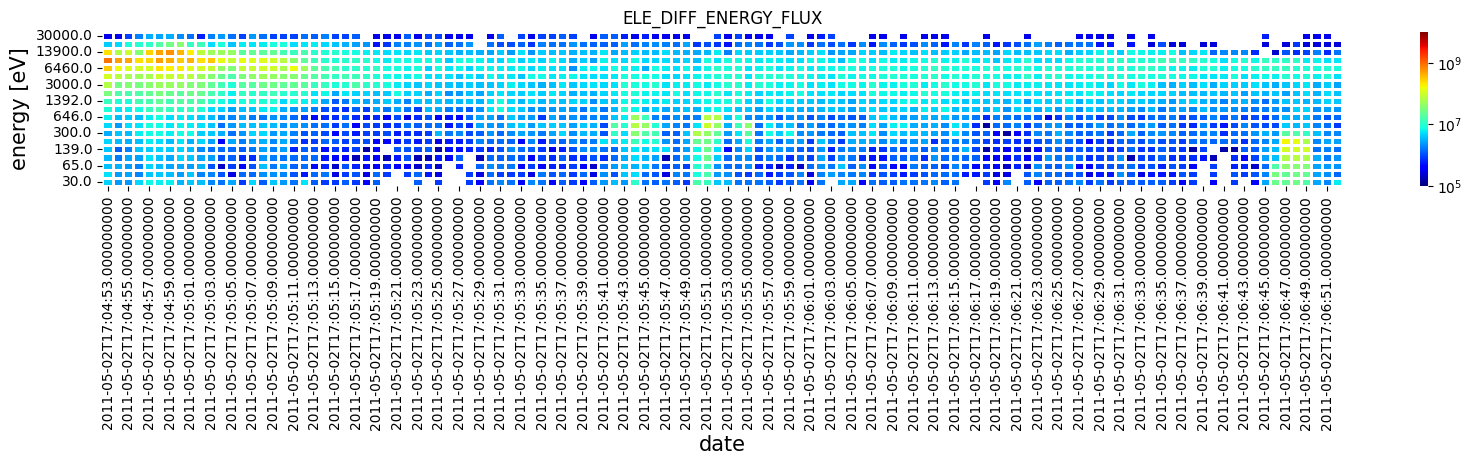

In [336]:
st = 61493
et = st + 120

df_ele = pd.DataFrame(ele.T[:, st:et], columns=date[st:et], index=channel)
df_ele_mask = (df_ele == 0)
plt.figure(figsize=(20,2))
sns.heatmap(df_ele, linewidths = 1,cmap = "jet", mask = df_ele_mask, norm=LogNorm(vmin=1e5,vmax=1e10))
plt.title('ELE_DIFF_ENERGY_FLUX')
plt.xlabel('date', fontsize=15)
plt.ylabel('energy [eV]', fontsize=15);

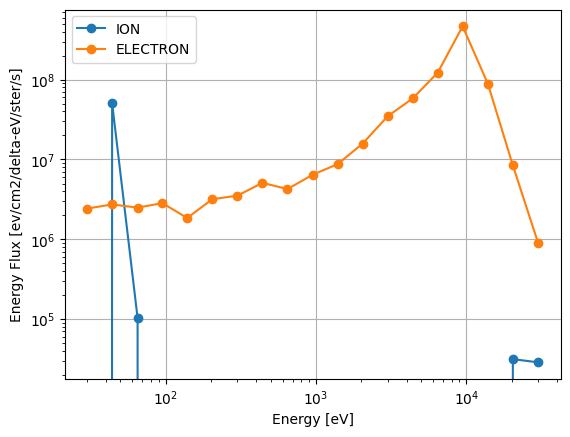

In [334]:
def plot_fig(id, ion, ele):
    plt.plot(channel, ion[id], marker='o', label='ION')
    plt.plot(channel, ele[id], marker='o', label='ELECTRON')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy Flux [ev/cm2/delta-eV/ster/s]')
    plt.grid()
    plt.legend()

plot_fig(61495, ion, ele)

In [178]:
df = np.array([ion.max(axis=1), ele.max(axis=1)])
df = pd.DataFrame(df.T, columns=['ION', 'ELECTRON'], index=date)

In [179]:
df

,ION,ELECTRON
2011-05-02 00:00:00,1.272880e+06,1.372338e+07
2011-05-02 00:00:01,1.272880e+06,5.862618e+06
2011-05-02 00:00:02,1.118591e+06,1.063947e+07
2011-05-02 00:00:03,1.195735e+06,1.820008e+07
2011-05-02 00:00:04,1.272880e+06,1.820008e+07
...,...,...
2011-05-02 23:59:55,2.156155e+05,3.018722e+05
2011-05-02 23:59:56,0.000000e+00,0.000000e+00
2011-05-02 23:59:57,0.000000e+00,0.000000e+00
2011-05-02 23:59:58,1.148218e+05,6.037443e+05


In [180]:
df_min = df.groupby(pd.Grouper(freq='min')).mean()

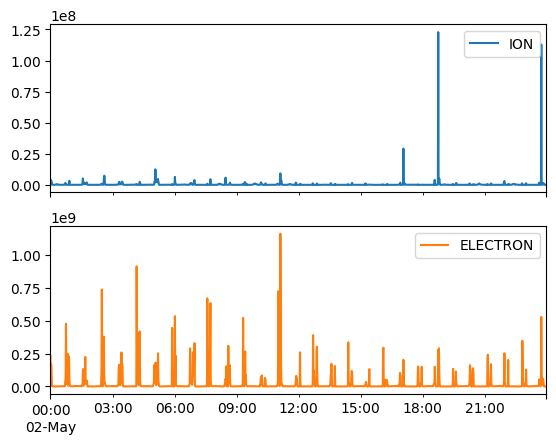

In [181]:
df_min.plot(subplots=True)
plt.legend();

In [234]:
tmp = []
for i, e in enumerate(ele):
    if any(e[:3] > 10**8):
        tmp.append(i)

In [339]:
import scipy.stats as stats

def smirnov_grubbs(data, alpha):
    x, o = list(data), []
    while True:
        n = len(x)
        t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)
        tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)
        i_min, i_max = np.argmin(x), np.argmax(x)
        myu, std = np.mean(x), np.std(x, ddof=1)
        i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
        tau_far = np.abs((x[i_far] - myu) / std)
        if tau_far < tau: break
        o.append(x.pop(i_far))
    return (np.array(x), np.array(o))

def detect_charge(ion, electron):
    check_id_list = []
    alpha = 0.01
    charge_id = []
    for i, ele in enumerate(electron):
        if any(ele[:4] > 1e8):
            check_id_list.append(i)

    for i in check_id_list:
        check_ion = ion[i][ion[i] > 0]
        if len(check_ion) <= 2:
            continue
        x_array, out_array = smirnov_grubbs(check_ion, alpha)
        if len(out_array) > 0 and any(out_array > 1e7):
            charge_id.append(i)
    return charge_id


In [340]:
ind = detect_charge(ion ,ele)

In [341]:
ele[61495]

array([9.0561650e+05, 8.4339250e+06, 8.9288880e+07, 4.6707258e+08,
       1.2310400e+08, 5.8262756e+07, 3.4899316e+07, 1.5786855e+07,
       8.7452630e+06, 6.4345800e+06, 4.2595560e+06, 5.0964825e+06,
       3.5251385e+06, 3.1749830e+06, 1.8503429e+06, 2.8373665e+06,
       2.4940212e+06, 2.7336390e+06, 2.4266770e+06], dtype=float32)

61493
(array([114717.81 ,  31441.54 ,  47181.42 ,  90430.695], dtype=float32), array([1.3953730e+08, 4.8490145e+06], dtype=float32))


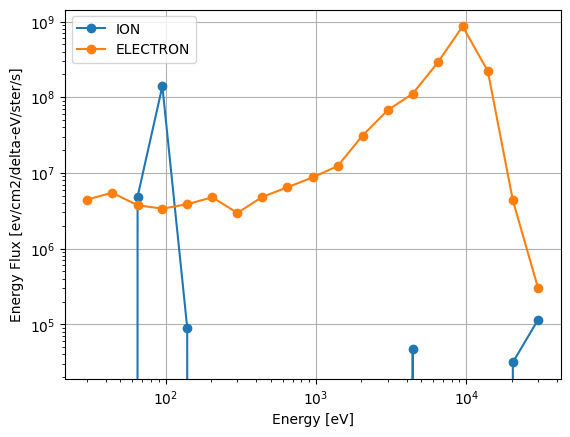

In [349]:
id = ind[4]
a = ion[id][ion[id] > 0]
alpha = 0.01
print(id)
print(smirnov_grubbs(a, alpha))
plot_fig(id, ion, ele)

In [345]:
ind

[139,
 140,
 219,
 61488,
 61493,
 61495,
 61496,
 61499,
 67515,
 67516,
 67517,
 67519,
 67520,
 67521,
 67522,
 67523,
 67524,
 67525,
 67526,
 67527,
 67529,
 67530,
 67531,
 67532,
 67533,
 67534,
 67535,
 67536,
 67537,
 67538,
 67539,
 67540,
 67541,
 67542,
 67543,
 67544,
 67545,
 67546,
 67547,
 67548,
 67549,
 85448,
 85449,
 85455,
 85456,
 85458,
 85459,
 85461,
 85462,
 85464,
 85465,
 85466,
 85467,
 85468,
 85469,
 85470]